# MCLP Simulation

### Below we will simulate tokenomics startegies for a Multi-Company-Loyalty-Program

### Model Description

##### This is a free-float tokenomics model for a multi-company-loyalty program. It uses a preprogrammed bonding curve to algorithmically control the token value based on the supply quantity.

##### Initially, for initalization 1 billion token are issued in a reserve. This doesnt affect the bonding curve yet, as the tokens are locked. The given partner-companies now can buy into the system converting token at a fixed rate for ICO. The token they accquire can either be staked (locked), not being regarded as circulating supply, thus, by the bonding curve, or they can be openly held for issuance, affecting the amount in circulation. When a customer makes a purchase at the partner company, token are rewarded based on an algorithmically defined issuance rate, that moves along the bonding curve, yet is only updated every month, thus, leaving room for speculation. The token flow into the customers wallet and can be redeemed. According to the position of the bonding curve, the token value changes. The token can be redeemed at any partner company. In case the prime quest is achieved the customer earns a 20% discount on redemption. 

##### Upon redemption the token flow back to the partner companies wallet. Each transaction, be it for issuance or redemption is validated using PoS by three partner companies randomly selected. Per block, 9 token are awareded from the reserve, wich are split between the validating companies. This mechanism keeps the system circular.


In [1]:
# To DOS:

# Integrate Tiers -- done
# Update Incentives for bonding curve mechanism -- done
# Integrate quarterly voting mechanism -- review competition effects
# Update growth rate -- done


In [118]:
# Import packages

import random
import matplotlib.pyplot as plt
import numpy as np


In [382]:
# Incentive Curves

# Define function for s-shaped incentive curve
def incentive_curve_sigmoid(x, max_value, midpoint):
    # Curve starts at 1 when x is 0
    base_adjustment = 1 - (max_value / (1 + np.exp(0.1 * midpoint)))
    return max_value / (1 + np.exp(-0.1 * (x - midpoint))) + base_adjustment


def incentive_curve_linear(x, max_value, slope):
    # Linear function starting at 1 when x is 0
    return max(min(slope * x + 1, max_value), 1)

def incentive_curve_root(x, max_value, midpoint):
    # Adjust the curve to start at 1
    base_adjustment = 1 - (max_value * np.sqrt(1 - midpoint) / np.sqrt(max_value + 1))
    return max(max_value * np.sqrt((x - midpoint) + 1) / np.sqrt(max_value + 1) + base_adjustment, 1)

In [383]:
# Define partner data
partners = {
    "Partner 1": {"Sales Events": 8245, "Average Basket Value": 121.29, "Industry": 1, "Staked Tokens": 0, "Total Tokens Held": 0},
    "Partner 2": {"Sales Events": 1002, "Average Basket Value": 49.90, "Industry": 2, "Staked Tokens": 0, "Total Tokens Held": 0},
    "Partner 3": {"Sales Events": 19003, "Average Basket Value": 31.57, "Industry": 2, "Staked Tokens": 0, "Total Tokens Held": 0},
    "Partner 4": {"Sales Events": 436, "Average Basket Value": 30257.19, "Industry": 3, "Staked Tokens": 0, "Total Tokens Held": 0},
}

# Account for competition effects

def calculate_competition_effect(partners, industry_competition_factor):
    industry_counts = {}
    competition_effects = {}

    # Count the number of partners in each industry
    for partner, data in partners.items():
        industry = data["Industry"]
        industry_counts[industry] = industry_counts.get(industry, 0) + 1

    # Calculate competition effect for each partner
    for partner, data in partners.items():
        industry = data["Industry"]
        # The more competitors, the stronger the negative effect
        competition_effect = 1 - (industry_counts[industry] - 1) * industry_competition_factor
        competition_effect = max(competition_effect, 0)  # Ensure it doesn't go negative
        competition_effects[partner] = competition_effect

    return competition_effects


industry_competition_factor = 0.05  # Example value
competition_effects = calculate_competition_effect(partners, industry_competition_factor)

# Adjust partner data based on competition effects
for partner in partners:
    competition_effect = competition_effects[partner]
    partners[partner]["Adjusted Sales Events"] = partners[partner]["Sales Events"] * competition_effect


def calculate_reward_metric(partners):
    metrics = {}
    for partner, data in partners.items():
        sales_increase_metric = data.get("Sales Increase", 0) * 0.33
        total_tokens_metric = data["Total Tokens Held"] * 0.33
        staked_tokens_metric = (data["Staked Tokens"] / data["Total Tokens Held"]) * 0.33 if data["Total Tokens Held"] > 0 else 0
        metrics[partner] = sales_increase_metric + total_tokens_metric + staked_tokens_metric
    return metrics



## Gamification


In [384]:
# To incentivize customers to transition to higher tiers, higher tiers have higher earning rates
# For example in Tier 3 0.15 Tokens are earned per dollar spent
tier_rates = {
    "Tier 1": 0.05,
    "Tier 2": 0.1,
    "Tier 3": 0.15
}

# Customers can slide into a higher tier by surpassing the accumulated spending thresholds
tier_thresholds = {
    "Tier 2": 500,
    "Tier 3": 1000
}

# Tier Maintenance is a gamification-mechanism that incentivizes customers to increase spending, as they may risk sliding down after one month
# The thresholds refer to monthly spending levels within the partner network that need to be exceeded in order to remain in the tier
tier_maintenance = {
    "Tier 2": 250,
    "Tier 3": 500
}

total_tokens_redeemed = {}


In [385]:
import numpy as np

def bonding_curve_root(current_supply, max_value, midpoint, asymptote_point):
    # Ensure the current_supply is always greater than or equal to 0
    adjusted_supply = max(0, current_supply - midpoint)

    # The value of the token increases with the square root of the adjusted supply
    token_value = max_value * np.sqrt(adjusted_supply + 1) / np.sqrt(asymptote_point + 1)

    # Ensure that the token value does not exceed the max_value
    return min(token_value, max_value)

# Parameters
max_value = 10  # Maximum token value
midpoint = 0    # Supply at which the value starts increasing
asymptote_point = 10000000  # Supply at which the curve asymptotically approaches max_value


In [386]:
# Initial token reserve
initial_reserve = 1e9  # 1 billion tokens

In [387]:
partners

{'Partner 1': {'Sales Events': 8245,
  'Average Basket Value': 121.29,
  'Industry': 1,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 8245.0},
 'Partner 2': {'Sales Events': 1002,
  'Average Basket Value': 49.9,
  'Industry': 2,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 951.9},
 'Partner 3': {'Sales Events': 19003,
  'Average Basket Value': 31.57,
  'Industry': 2,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 18052.85},
 'Partner 4': {'Sales Events': 436,
  'Average Basket Value': 30257.19,
  'Industry': 3,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 436.0}}

In [388]:
import numpy as np

def calculate_initial_buy_in(sales_events, current_token_price=0.1, min_monetary_buy_in=1000):
    # Introduce additional randomness factor
    randomness_factor = np.random.uniform(0.8, 1.2)

    # Adjusted parameters to set a minimum monetary buy-in value
    m = 0.5 * randomness_factor  # Adjusted slope with randomness
    c = min_monetary_buy_in * randomness_factor  # Minimum monetary value with randomness

    # Calculate the monetary buy-in based on sales events
    monetary_buy_in = m * (sales_events/6) + c

    # Add more randomness using normal distribution
    mu = monetary_buy_in
    sigma = 2000  # Increased variability
    random_monetary_buy_in = np.random.normal(mu, sigma)

    # Ensure the final buy-in money value is at least the minimum
    final_monetary_buy_in = max(c, int(random_monetary_buy_in))

    # Convert monetary value to number of tokens based on current price
    tokens_to_buy = final_monetary_buy_in / current_token_price

    return max(int(tokens_to_buy), 5000)  # Ensure at least 5000 tokens as minimum

    # Update partner data with initial token buy-in
for partner_name, data in partners.items():
    initial_tokens = calculate_initial_buy_in(data["Sales Events"])
    data["Initial Tokens"] = initial_tokens
    data["Tokens in Circulation"] = True

        
    





# Example output
for partner_name, data in partners.items():
    print(f"{partner_name}: {data}")


Partner 1: {'Sales Events': 8245, 'Average Basket Value': 121.29, 'Industry': 1, 'Staked Tokens': 0, 'Total Tokens Held': 0, 'Adjusted Sales Events': 8245.0, 'Initial Tokens': 16580, 'Tokens in Circulation': True}
Partner 2: {'Sales Events': 1002, 'Average Basket Value': 49.9, 'Industry': 2, 'Staked Tokens': 0, 'Total Tokens Held': 0, 'Adjusted Sales Events': 951.9, 'Initial Tokens': 11570, 'Tokens in Circulation': True}
Partner 3: {'Sales Events': 19003, 'Average Basket Value': 31.57, 'Industry': 2, 'Staked Tokens': 0, 'Total Tokens Held': 0, 'Adjusted Sales Events': 18052.85, 'Initial Tokens': 10450, 'Tokens in Circulation': True}
Partner 4: {'Sales Events': 436, 'Average Basket Value': 30257.19, 'Industry': 3, 'Staked Tokens': 0, 'Total Tokens Held': 0, 'Adjusted Sales Events': 436.0, 'Initial Tokens': 11900, 'Tokens in Circulation': True}


In [389]:
partners

{'Partner 1': {'Sales Events': 8245,
  'Average Basket Value': 121.29,
  'Industry': 1,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 8245.0,
  'Initial Tokens': 16580,
  'Tokens in Circulation': True},
 'Partner 2': {'Sales Events': 1002,
  'Average Basket Value': 49.9,
  'Industry': 2,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 951.9,
  'Initial Tokens': 11570,
  'Tokens in Circulation': True},
 'Partner 3': {'Sales Events': 19003,
  'Average Basket Value': 31.57,
  'Industry': 2,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 18052.85,
  'Initial Tokens': 10450,
  'Tokens in Circulation': True},
 'Partner 4': {'Sales Events': 436,
  'Average Basket Value': 30257.19,
  'Industry': 3,
  'Staked Tokens': 0,
  'Total Tokens Held': 0,
  'Adjusted Sales Events': 436.0,
  'Initial Tokens': 11900,
  'Tokens in Circulation': True}}

In [390]:
class CustomerM:

    id_counter = 0  # Static counter for unique IDs

    BASE_SPEND_PROBABILITY = 0.5  # 50% chance to spend without any incentives
    TOKEN_VALUE = 0.1  # Set a default value for TOKEN_VALUE
    ISSUE_RATE = 0.01 # This means customers earn 0.01 tokens for each unit of spend

    def __init__(self):
        self.id = CustomerM.id_counter
        CustomerM.id_counter += 1
        self.tier = "Tier 1"   # Initialize each customer as Tier 1
        self.total_spent = 0   # Token spent = 0
        self.tokens = 0        # Token held = 0
        self.current_month_spent = 0      # Token spent current month = 0
        self.savings = 0   # cumulative savings
        self.monthly_spending = [0] * 12  # Initialize with 0 spending for each of the 12 months

    TIER_SPEND_VALUES = {
        "Tier 1": 0,   # Base x-value for Tier 1
        "Tier 2": 1,   # Base x-value for Tier 2
        "Tier 3": 2    # Base x-value for Tier 3
    }

    def update_tier(self):
        new_tier = self.tier  # Start by assuming current tier

        if self.total_spent >= tier_thresholds["Tier 3"]:
            new_tier = "Tier 3"
        elif self.total_spent >= tier_thresholds["Tier 2"]:
            new_tier = "Tier 2"
        else:
            new_tier = "Tier 1"

        # Maintenance
        if new_tier == "Tier 3" and self.current_month_spent < tier_maintenance["Tier 3"]:
            new_tier = "Tier 2"
        if new_tier == "Tier 2" and self.current_month_spent < tier_maintenance["Tier 2"]:
            new_tier = "Tier 1"

        self.tier = new_tier
        self.current_month_spent = 0

    def bonding_c_R(current_supply, max_value=10, midpoint=0, asymptote_point=1000000000):
        # Ensure the current_supply is always greater than or equal to 0
        adjusted_supply = max(0, current_supply - midpoint)

        # The value of the token increases with the square root of the adjusted supply
        token_value = max_value * np.sqrt(adjusted_supply + 1) / np.sqrt(asymptote_point + 1)

        # Ensure that the token value does not exceed the max_value
        return min(token_value, max_value)


    def bonding_c_S(x, L, k, x0):
        L = 10  # Maximum value: 1 TKN = 10€
        k = 0.001 # Arbitrary steepness value
        x0 = 50000  # Assuming midpoint is at 500 tokens for demonstration purposes
        return L / (1 + np.exp(-k * (x - x0)))
    
    def calculate_monthly_curve_shift(current_month, total_supply, max_value=10, midpoint=0, asymptote_point=1000000000):
        # Calculate the current token value based on the new bonding curve
        current_token_value = CustomerM.bonding_c_R(total_supply, max_value, midpoint, asymptote_point)

        # Determine the relative position on the curve
        # For simplicity, we use the current token value divided by the max_value
        relative_position = current_token_value / max_value

        # The potential for appreciation is higher when the relative position is low
        # Using a simple linear relationship for this example: 
        # (1 - relative_position) gives higher values for lower positions on the curve
        curve_shift = (1 - relative_position) * 0.1  # Adjust the multiplier as needed

        return curve_shift
    
    ''''
    def calculate_initial_buy_in(total_supply, sales_events, min_monetary_buy_in=5000, max_value=10, midpoint=0, asymptote_point=1000000000):

        current_token_price = CustomerM.bonding_c_R(total_supply, max_value, midpoint, asymptote_point)
        # Introduce additional randomness factor
        randomness_factor = np.random.uniform(0.8, 1.2)

        # Adjusted parameters to set a minimum monetary buy-in value
        m = 0.5 * randomness_factor  # Adjusted slope with randomness
        c = min_monetary_buy_in * randomness_factor  # Minimum monetary value with randomness

        # Calculate the monetary buy-in based on sales events
        monetary_buy_in = m * sales_events + c

        # Add more randomness using normal distribution
        mu = monetary_buy_in
        sigma = 2000  # Increased variability
        random_monetary_buy_in = np.random.normal(mu, sigma)

        # Ensure the final buy-in money value is at least the minimum
        final_monetary_buy_in = max(c, int(random_monetary_buy_in))

        # Convert monetary value to number of tokens based on current price
        tokens_to_buy = final_monetary_buy_in / current_token_price

            # Update partner data with initial token buy-in
        for partner_name, data in partners.items():
            initial_tokens = calculate_initial_buy_in(data["Sales Events"])
            data["Initial Tokens"] = initial_tokens
            data["Tokens in Circulation"] = True
            
        return max(int(tokens_to_buy), 5000)  # Ensure at least 5000 tokens as minimum
    '''
   

    @classmethod
    def update_token_value(cls, total_supply, TOKEN_VALUE=0.1):
        max_value = 10  # Maximum value: 1 TKN = 10€
        midpoint = 0  # Set the midpoint for the bonding curve
        asymptote_point = 1000000000  # Asymptotic point for the curve

        # Calculate the current token value using the new bonding curve
        calculated_value = CustomerM.bonding_c_R(total_supply, max_value, midpoint, asymptote_point)

        # Ensure the token value does not fall below the floor value
        cls.TOKEN_VALUE = max(calculated_value, TOKEN_VALUE)



    def incentive_to_spend(self, curve_shift):
        # Base x-value from tier
        base_x_value = self.TIER_SPEND_VALUES[self.tier]

        # Adding token-based component to x-value
        token_component = 0.01 * self.tokens

        # Token appreciation component
        # Lower position on the curve indicates higher potential for appreciation
        token_appreciation_component = 1.0 - (self.TOKEN_VALUE / 10.0)  # Assuming maximum token value is 10

        # Trend component based on monthly bonding curve shifts
        # Positive shift increases incentive, negative shift decreases it
        trend_component = curve_shift * 5  # Use the passed curve_shift value

        # Introducing randomness using normal distribution
        random_component = np.random.normal(0, 0.2)

        # Total x-value for incentive curve with randomness
        x_value = base_x_value + token_component + token_appreciation_component + trend_component + random_component

        # Using your chosen incentive curve function with the calculated x-value
        # Replace with prefered incentive curve function and parameters
        multiplier = incentive_curve_linear(x_value, slope=0.5, max_value=5.0)

        # Calculating incentive probability
        incentive_prob = self.BASE_SPEND_PROBABILITY * multiplier

        # Ensure the probability does not exceed 1
        return min(incentive_prob, 1)

    def spend(self, partners, curve_shift):
        # Use Adjusted Sales Events for partner probabilities
        partner_probabilities = [data.get("Adjusted Sales Events", data.get("Sales Events")) / 12 for _, data in partners.items()]
        total_events = sum(partner_probabilities)
        partner_probabilities = [p / total_events for p in partner_probabilities]
        
        should_spend = random.random() < self.incentive_to_spend(curve_shift)
        if should_spend:
            partner = random.choices(list(partners.keys()), weights=partner_probabilities, k=1)[0]
            spend_value = random.uniform(0, partners[partner]["Average Basket Value"] * 2)
            self.total_spent += spend_value
            return partner, spend_value
        return None, 0

    def earn_tokens(self, spend_value):
        """
        Calculates tokens earned based on spend value and ISSUE_RATE.
        """

        # Ensure that TOKEN_VALUE is the current value from the bonding curve
        current_token_value = self.TOKEN_VALUE

        earn_rate = tier_rates[self.tier]

        # Calculate tokens earned
        tokens_earned = (spend_value * earn_rate) / current_token_value

        # Update the number of tokens
        self.tokens += tokens_earned

        partners[partner]["Wallet"] -= tokens_earned  # Deduct tokens from partner's wallet

        # Return the number of tokens earned
        return tokens_earned

    def redeem_tokens(self, partner, mean_rate=0.20, std_dev=0.2):
        
        # Existing logic to calculate redeemed tokens
        sampled_rate = np.random.normal(mean_rate, std_dev)
        sampled_rate = max(0, min(1, sampled_rate))
        redeemed_tokens = self.tokens * sampled_rate
        redeemed_value = redeemed_tokens * self.TOKEN_VALUE

        # Deduct redeemed tokens from customer
        self.tokens -= redeemed_tokens

        # Add redeemed tokens back to partner's wallet
        partners[partner]["Wallet"] += redeemed_tokens

        # Return both redeemed tokens and their value
        return redeemed_tokens, redeemed_value
    
    def calculate_competition_effect(partners, industry_competition_factor):
        industry_counts = {}
        competition_effects = {}

        # Count the number of partners in each industry
        for partner, data in partners.items():
            industry = data["Industry"]
            industry_counts[industry] = industry_counts.get(industry, 0) + 1

        # Calculate competition effect for each partner
        for partner, data in partners.items():
            industry = data["Industry"]
            # The more competitors, the stronger the negative effect
            competition_effect = 1 - (industry_counts[industry] - 1) * industry_competition_factor
            competition_effect = max(competition_effect, 0)  # Ensure it doesn't go negative
            competition_effects[partner] = competition_effect

        return competition_effects
    
    def purchase_additional_tokens(partners, total_supply, recent_spending_data, market_trends, current_month, customer_growth_rate=0.07):
        for partner, data in partners.items():
            if len(recent_spending_data[partner]) > 0:
                # Calculate the dynamic threshold based on recent spending
                average_recent_spending = sum(recent_spending_data[partner]) / len(recent_spending_data[partner])
                dynamic_threshold = average_recent_spending * (1.1 + customer_growth_rate * current_month)  # 10% above average recent spending + growth factor

                # Consider market trends and seasonality
                market_trend_factor = market_trends[partner] * (1 + customer_growth_rate * current_month)  # Adjusting for customer growth

                # Token price trend consideration
                current_token_price = CustomerM.bonding_c_R(total_supply, max_value, midpoint, asymptote_point)
                expected_future_price = CustomerM.bonding_c_R(total_supply + 10000, max_value, midpoint, asymptote_point)
                price_trend_factor = expected_future_price / current_token_price

                # Introduce some randomness to the decision-making process
                random_factor = np.random.uniform(0.95, 1.05)

                # Decide if buying tokens is beneficial
                if data["Wallet"] < dynamic_threshold and price_trend_factor * random_factor > 1.001:
                    tokens_to_buy = max(0, dynamic_threshold - data["Wallet"]) * market_trend_factor
                    token_price = CustomerM.bonding_c_R(total_supply + tokens_to_buy, max_value, midpoint, asymptote_point)

                    # Update partner's wallet and total supply
                    data["Wallet"] += tokens_to_buy
                    total_supply += tokens_to_buy

                    # Record transaction for analysis
                    data["Token Purchases"][current_month].append((tokens_to_buy, token_price))

        return total_supply



    REWARD_PER_BLOCK = 90

    # PoS Validation
    def pos_validation(partners, transactions, reward_per_block=REWARD_PER_BLOCK):
        for transaction in transactions:
            validating_partners = random.sample(list(partners.keys()), 3)  # Select 3 random partners for validation
            for partner in validating_partners:
                partners[partner]["Wallet"] += reward_per_block / 3  # Distribute rewards evenly
        return partners

    def stake_tokens(partner_name, amount, partners):
        if amount <= partners[partner_name]["Wallet"]:
            partners[partner_name]["Staked Tokens"] += amount
            partners[partner_name]["Wallet"] -= amount

    def calculate_reward_metric(partners):
        metrics = {}
        for partner, data in partners.items():
            if data["Total Sales Per Month"]:
                current_sales = data["Total Sales Per Month"][-1]  # The last element for the current month's sales
                # Placeholder calculation for sales increase. Replace this with your actual calculation.
                previous_sales = data.get("Previous Sales", 1)  # Use 1 to avoid division by zero if previous sales data is missing
                current_sales = data["Total Sales Per Month"][-1]  # Assuming this is the current month's sales
                sales_increase = ((current_sales - previous_sales) / previous_sales) * 100 if previous_sales > 0 else 0

                # Calculate total number of tokens held (circulation + locked)
                total_tokens_held = data["Wallet"] + data.get("Staked Tokens", 0)

                # Calculate proportion of staked tokens
                proportion_staked = data.get("Staked Tokens", 0) / total_tokens_held if total_tokens_held > 0 else 0

                # Calculate the weighted metric
                metric = 0.2 * sales_increase + 0.4 * total_tokens_held + 0.4 * proportion_staked
                metrics[partner] = metric
            
            else:
                current_sales = 0  # Default to 0 if no sales data is available

        return metrics
    
    def calculate_customer_growth(initial_customer_count, month, base_growth_rate=0.03, diminishing_factor_min=0.90, diminishing_factor_max=0.99):
        """
        Calculate the number of customers for the current month with diminishing and random growth.

        :param initial_customer_count: The initial number of customers.
        :param month: The current month in the simulation.
        :param base_growth_rate: The base monthly growth rate.
        :param diminishing_factor_min: The minimum value for the random diminishing factor.
        :param diminishing_factor_max: The maximum value for the random diminishing factor.
        :return: The calculated number of customers for the current month.
        """
        current_growth_rate = base_growth_rate
        total_growth = 0

        # Apply diminishing and random growth rate for each month
        for m in range(1, month + 1):
            total_growth += current_growth_rate
            random_diminishing_factor = random.uniform(diminishing_factor_min, diminishing_factor_max)
            current_growth_rate *= random_diminishing_factor

        additional_customers = initial_customer_count * total_growth
        return initial_customer_count + int(additional_customers)


    def stake_tokens(partner_name, percentage, partners, month):
        tokens_to_stake = partners[partner_name]["Wallet"] * percentage
        partners[partner_name]["Staked Tokens"] += tokens_to_stake
        partners[partner_name]["Wallet"] -= tokens_to_stake
        # Record the staked tokens for the current month
        partners[partner_name]["Monthly Staked Tokens"][month] = tokens_to_stake
        return tokens_to_stake  # Return the amount of tokens staked



    def random_staking_decision(partners, min_percentage, max_percentage, month):
        for partner in partners:
            stake_percentage = random.uniform(min_percentage, max_percentage)
            CustomerM.stake_tokens(partner, stake_percentage, partners, month)



    @staticmethod
    def generate_new_partner_data():
        # Simulate the generation of new partner data
        simulated_sales = random.randint(500, 30000)  # Random sales between 500 and 30,000
        average_basket_value = random.randint(5, 500)   # Random average basket value between 5 and 500

        # Example: Using a power function to reduce the frequency of hitting the ceiling
        # Calculate the size factor based on sales and average basket value with more variability
        # Introduce a power function and a randomness factor
        randomness_factor = random.uniform(0.01, 0.1)  # Random factor 
        size_factor = (((simulated_sales / 100000) ** 0.5 + (average_basket_value / 500) ** 0.5) / 2) * randomness_factor


        # Ensuring the size factor doesn't exceed the maximum limit of 20%
        max_size_factor = 0.2
        size_factor = min(size_factor, max_size_factor)

        return {
            "Sales Events": simulated_sales,
            "Average Basket Value": average_basket_value,
            "Industry": random.randint(1, 5),
            "size_factor": size_factor  
        }

    def conduct_vote(existing_partners, new_partner_applications):
        accepted_partners = []

        for new_partner_data in new_partner_applications:
            # Counting the number of yes votes
            yes_votes = 0
            total_votes = len(existing_partners) + 1  # Including the third party

            # Votes from existing partners
            for _ in existing_partners:
                vote = random.choice([True, False])  # Random vote for each partner
                if vote:
                    yes_votes += 1

            # Third-party vote
            third_party_vote = random.choice([True, False])
            if third_party_vote:
                yes_votes += 1

            # Determine if the new partner is accepted
            if yes_votes > total_votes / 2:
                accepted_partners.append(new_partner_data)

        return accepted_partners
    

    @staticmethod
    def initialize_new_partner(partner_data):
       # Use the default current token price or specify if different
        initial_tokens = calculate_initial_buy_in(partner_data["Sales Events"], CustomerM.TOKEN_VALUE)

        return {
            "Initial Tokens": initial_tokens,
            "Wallet": initial_tokens,
            "Staked Tokens": 0,
            "Total Tokens Held": initial_tokens,
            "Total Sales Per Month": [0] * 12,
            "Token Purchases": [[] for _ in range(12)],
            "Monthly Staked Tokens": [0] * 12,
            "Sales Events": partner_data["Sales Events"],  # Add Sales Events
            "Average Basket Value": partner_data["Average Basket Value"],  # Add Average Basket Value
            "Industry": partner_data["Industry"],  # Add Industry
            # Add other necessary fields from partner_data if required
        }





In [391]:
# Circular token flow -- done
# Adjust bonding curve -- to do
# Add staking reward-mechanism for partner companies -- done
# Add gamifiction for prime tier -- to do
# Add appreciation component to incentive to spend -- done

In [392]:


# ... (Assuming CustomerM class and other necessary functions and imports are already defined) ...

def run_simulation(customers_count, partners):
    # Initialization

    monthly_customer_counts = []  # Add this list to store monthly customer counts

    monthly_token_circulation = []
    monthly_token_values = []  # List to store token values for each month
    monthly_token_supply = []  # List to store token supply for each month

    # Initialize a dictionary for PoS rewards
    pos_rewards = {partner: 0 for partner in partners.keys()}

    initial_customers_count = customers_count  # The initial number of customers
    initial_customers = [CustomerM() for _ in range(initial_customers_count)]  # Starting number of customers
    customers = [CustomerM() for _ in range(customers_count)]
    total_tokens_redeemed = {partner: 0 for partner in partners}
    wallet_values = {}
  
    total_customers_count = initial_customers_count  # Initialize total customers count

    # Initialize customer_savings_ST for initial customers
    customer_savings_ST = {customer.id: [0] * 12 for customer in initial_customers}


    recent_spending_data = {partner: [] for partner in partners}  # Initialize recent spending data
    market_trends = {partner: 1.0 for partner in partners}  # Initialize market trends (1.0 represents no change)

    # Initialize Wallet for each partner based on their initial token buy-in
    for partner, data in partners.items():
        data["Total Sales Per Month"] = [0] * 12  # Initialize with zeros for each of the 12 months
        data["Wallet"] = data["Initial Tokens"]  # Set Wallet equal to Initial Tokens
        data["Token Purchases"] = [[] for _ in range(12)]  # 12 lists for 12 months
        data["Monthly Staked Tokens"] = [0] * 12  # Initialize with 12 months, assuming a yearly simulation

    total_supply = sum(partner_data["Wallet"] for partner_data in partners.values())

    # Initialize partner_metrics
    partner_metrics = {
        partner: {
            "Purchases Per Month": [0] * 12,
            "Unique Customers Per Month": [0] * 12,  # Initialize as zero counts
            "Total Sales Per Month": [0] * 12,
            "Average Basket Value Per Month": [0] * 12,
            "Tokens Redeemed Per Month": [0] * 12
        }
        for partner in partners
    }


    tier_distribution = {"Tier 1": 0, "Tier 2": 0, "Tier 3": 0}

    # Monthly simulation loop
    for month in range(12):

        # Quarterly Voting for New Partners
        # Quarterly Voting for New Partners
        quarter_counter = 0
        # Calculate the average size of the initial partners
        initial_partner_sizes = [partners[partner]['Sales Events'] for partner in partners]
        average_initial_size = sum(initial_partner_sizes) / len(initial_partner_sizes) if initial_partner_sizes else 1

                # Calculate the total number of customers for this month
        # Base customer growth without new partners
        base_customers_count = CustomerM.calculate_customer_growth(initial_customers_count, month)
        additional_customers_for_new_partners = 0
        
        # Quarterly voting for new partners
        if month % 3 == 0:
            # Calculate the average size of the initial partners
            initial_partner_sizes = [partners[partner]['Sales Events'] for partner in partners]
            average_initial_size = sum(initial_partner_sizes) / len(initial_partner_sizes) if initial_partner_sizes else 1

            num_applications = random.randint(0, 2)
            new_partner_applications = [CustomerM.generate_new_partner_data() for _ in range(num_applications)]
            accepted_partners = CustomerM.conduct_vote(partners, new_partner_applications)

            for accepted_partner_data in accepted_partners:
                new_partner_size_proportion = accepted_partner_data['Sales Events'] / average_initial_size
                new_partner_additional_customers = int(base_customers_count * new_partner_size_proportion)
                additional_customers_for_new_partners += new_partner_additional_customers

                partner_name = f"New Partner {len(partners) + 1}"
                new_partner = CustomerM.initialize_new_partner(accepted_partner_data)
                partners[partner_name] = new_partner


                # Initialize necessary keys for the new partner
                partners[partner_name]["Wallet"] = calculate_initial_buy_in(partners[partner_name]["Sales Events"], current_token_price)
                partners[partner_name]["Staked Tokens"] = 0
                partners[partner_name]["Initial Tokens"] = partners[partner_name]["Wallet"]

                # Initialize metrics for the new partner
                partner_metrics[partner_name] = {
                    "Purchases Per Month": [0] * 12,
                    "Unique Customers Per Month": [0] * 12,
                    "Total Sales Per Month": [0] * 12,
                    "Average Basket Value Per Month": [0] * 12,
                    "Tokens Redeemed Per Month": [0] * 12
                }

                # Initialize PoS rewards, recent spending data, and market trends for new partner
                total_tokens_redeemed[partner_name] = 0
                pos_rewards[partner_name] = 0
                recent_spending_data[partner_name] = [] 
                market_trends[partner_name] = 1.0  # Default value for new partner

                 # Add new customers for new partners and update total customer count
            for _ in range(additional_customers_for_new_partners):
                new_customer = CustomerM()
                initial_customers.append(new_customer)
                customer_savings_ST[new_customer.id] = [0] * 12
            total_customers_count += additional_customers_for_new_partners

        # Update the number of customers for this month based on total customer count
        customers_count_this_month = CustomerM.calculate_customer_growth(total_customers_count, month)

        # Ensure all customers are accounted for in the simulation
        while len(initial_customers) < customers_count_this_month:
            new_customer = CustomerM()
            initial_customers.append(new_customer)
            customer_savings_ST[new_customer.id] = [0] * 12

        monthly_customer_counts.append(len(initial_customers))



        # Calculate the curve shift for the current month
        curve_shift = CustomerM.calculate_monthly_curve_shift(month, total_supply, max_value=10, midpoint=0, asymptote_point=1000000000)
        monthly_total_spending = {partner: 0 for partner in partners}
        unique_customers_tracker = {partner: set() for partner in partners}

        transactions = []  # list of transactions that occurred in the month

        for customer in customers:
            num_shops = random.randint(0, 5)
            for _ in range(num_shops):
                partner, spend_value = customer.spend(partners, curve_shift)
                if partner:
                     # Record spending transaction
                    spending_transaction = {
                        'customer': customer,
                        'partner': partner,
                        'amount': spend_value,
                        'type': 'spend'
                    }
                    transactions.append(spending_transaction)

                    # Customer earns tokens
                    tokens_earned = customer.earn_tokens(spend_value)

                    # Record partner metrics
                    partner_metrics[partner]["Purchases Per Month"][month] += 1
                    unique_customers_tracker[partner].add(customer)
                    partner_metrics[partner]["Total Sales Per Month"][month] += spend_value

                    # Update 'Total Sales Per Month' for the partner
                    if len(partners[partner]["Total Sales Per Month"]) < month + 1:
                        partners[partner]["Total Sales Per Month"].extend([0] * (month + 1 - len(partners[partner]["Total Sales Per Month"])))
                    partners[partner]["Total Sales Per Month"][month] += spend_value

                    # Customer redeems tokens
                    # Redeeming tokens
                    redeemed_tokens, redeemed_value = customer.redeem_tokens(partner)
                    if redeemed_tokens:
                        # Ensure the customer ID exists in the customer_savings_ST before updating it
                        if customer.id in customer_savings_ST:
                            customer_savings_ST[customer.id][month] += redeemed_value
                        else:
                            # Handle the case where the customer ID is not in the dictionary
                            customer_savings_ST[customer.id] = [0] * 12
                            customer_savings_ST[customer.id][month] = redeemed_value

                        # Update partner metrics for tokens redeemed
                        if month < len(partner_metrics[partner]["Tokens Redeemed Per Month"]):
                            partner_metrics[partner]["Tokens Redeemed Per Month"][month] += redeemed_tokens
                        else:
                            partner_metrics[partner]["Tokens Redeemed Per Month"].extend([0] * (month + 1 - len(partner_metrics[partner]["Tokens Redeemed Per Month"])))
                            partner_metrics[partner]["Tokens Redeemed Per Month"][month] += redeemed_tokens

                    customer.current_month_spent += spend_value

            customer.update_tier()
            tier_distribution[customer.tier] += 1


        # Update token value based on the new total supply
        CustomerM.update_token_value(total_supply)



        # PoS validation after all transactions
        CustomerM.random_staking_decision(partners, 0.05, 0.2, month) 
        num_blocks = len(transactions) // 100
        for block in range(num_blocks):
            metrics = CustomerM.calculate_reward_metric(partners)
            total_metric = sum(metrics.values())

            # Distribute rewards
            for partner in partners.keys():
                if total_metric > 0:
                    reward = (metrics[partner] / total_metric) * CustomerM.REWARD_PER_BLOCK
                    reward = max(reward, 0)  # Ensure reward is not negative
                else:
                    reward = 0

                partners[partner]["Wallet"] += reward
                pos_rewards[partner] += reward  


        # Partners may buy additional tokens based on their projected demand
        total_supply = CustomerM.purchase_additional_tokens(partners, total_supply, recent_spending_data, market_trends, month)

        staked_tokens_this_month = sum(partner_data["Monthly Staked Tokens"][month] for partner_data in partners.values())
        total_supply -= staked_tokens_this_month
        
        # Calculate total tokens in customer and partner wallets
        total_customer_tokens = sum(customer.tokens for customer in customers)
        total_partner_tokens = sum(partner_data["Wallet"] for partner_data in partners.values())
        current_tokens_in_circulation = total_customer_tokens + total_partner_tokens
        monthly_token_circulation.append(current_tokens_in_circulation)

        monthly_token_supply.append(total_supply)

        monthly_token_values.append(CustomerM.TOKEN_VALUE)

        # Update token value
        CustomerM.update_token_value(total_supply)

        # Update average basket value at the end of each month for each partner
        for partner in partners:
            total_sales = partner_metrics[partner]["Total Sales Per Month"][month]
            num_purchases = partner_metrics[partner]["Purchases Per Month"][month]
            monthly_total_spending[partner] += partner_metrics[partner]["Total Sales Per Month"][month]
            recent_spending_data[partner].append(monthly_total_spending[partner])
            if num_purchases > 0:
                partner_metrics[partner]["Average Basket Value Per Month"][month] = total_sales / num_purchases


        # Update unique customer counts after all transactions are done for the month
        for partner in partners:
            partner_metrics[partner]["Unique Customers Per Month"][month] = len(unique_customers_tracker[partner])

        # Update competition effects at the end of each month
        competition_effects = CustomerM.calculate_competition_effect(partners, industry_competition_factor)


    # Final aggregation of wallet values
    for customer in customers:
        wallet_values[customer] = customer.tokens  # Update wallet values for each customer

    # Final aggregation and calculation of metrics after the simulation loop
    total_wallet_value = sum(wallet_values.values())  # Calculate the total value of all wallets
    average_wallet_value = total_wallet_value / customers_count if customers_count > 0 else 0  # Calculate the average wallet value

    return total_tokens_redeemed, tier_distribution, partner_metrics, wallet_values, average_wallet_value, customer_savings_ST, pos_rewards, monthly_token_values, monthly_token_supply, monthly_token_circulation, monthly_customer_counts





In [313]:
monthly_customer_counts

[204, 210, 215, 221, 226, 230, 492, 498, 514, 768, 781, 790]

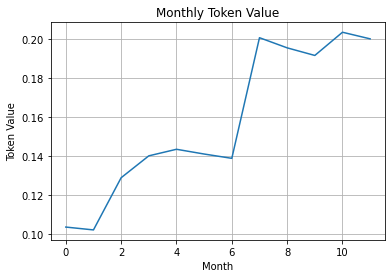

In [314]:
# Plotting the monthly token values
import matplotlib.pyplot as plt

plt.plot(monthly_token_values)
plt.title('Monthly Token Value')
plt.xlabel('Month')
plt.ylabel('Token Value')
plt.grid(True)
plt.show()

## KPI

In [393]:
import numpy as np

def calculate_total_average_customer_retention(partner_metrics):
    total_monthly_increase = {}
    total_percent_increases = []

    for partner, data in partner_metrics.items():
        monthly_sales_per_customer = {}

        # Calculate average sales per customer for each month
        for month in range(12):
            unique_customers = data["Unique Customers Per Month"][month]
            if isinstance(unique_customers, (set, list)):
                unique_customers = len(unique_customers)
                
            if unique_customers > 0:
                avg_sales = data["Total Sales Per Month"][month] / unique_customers
                monthly_sales_per_customer[month] = avg_sales

        # Calculate monthly sales increase
        for month in range(1, 12):
            if month in monthly_sales_per_customer and month-1 in monthly_sales_per_customer:
                last_month_sales = monthly_sales_per_customer[month - 1]
                current_month_sales = monthly_sales_per_customer[month]
                increase_percent = ((current_month_sales - last_month_sales) / last_month_sales) * 100 if last_month_sales > 0 else 0
                total_monthly_increase.setdefault(month, []).append(increase_percent)

    # Averaging monthly increase percentages across all partners and months
    for month, increases in total_monthly_increase.items():
        if increases:
            avg_increase = sum(increases) / len(increases)
            total_percent_increases.append(avg_increase)

    # Calculate the overall average increase
    total_average_increase = sum(total_percent_increases) / len(total_percent_increases) if total_percent_increases else 0

    return total_average_increase


# Usage example
# partner_monthly_increase, total_monthly_increase = calculate_customer_retention(partner_metrics)



def calculate_npv(partner_metrics, partner_metrics_baseline, monthly_tokens_redeemed, token_value=0.5, discount_rate=0.05):
    npv_values = {}
    total_npv = 0

    for partner, data in partner_metrics.items():
        monthly_revenues = data["Total Sales Per Month"]
        baseline_monthly_revenues = partner_metrics_baseline[partner]["Total Sales Per Month"]
        monthly_token_redemptions = monthly_tokens_redeemed[partner]

        npv = 0
        for month in range(12):
            incremental_revenue = monthly_revenues[month] - baseline_monthly_revenues[month]
            costs = monthly_token_redemptions[month] * token_value
            net_cash_flow = incremental_revenue - costs
            discounted_cash_flow = net_cash_flow / ((1 + discount_rate) ** (month / 12))
            npv += discounted_cash_flow

        npv_values[partner] = npv
        total_npv += npv

    return total_npv


def extract_monthly_tokens_redeemed(partner_metrics):
    monthly_tokens_redeemed = {}
    for partner, data in partner_metrics.items():
        monthly_tokens_redeemed[partner] = data["Tokens Redeemed Per Month"]
    return monthly_tokens_redeemed


def calculate_system_equity(partner_metrics):
    monthly_growth_std_dev = []
    all_growth_rates = []  # List to store all growth rates for total equity calculation

    for month in range(1, 12):
        monthly_growth = []
        for partner, data in partner_metrics.items():
            last_month_sales = data["Total Sales Per Month"][month - 1]
            current_month_sales = data["Total Sales Per Month"][month]
            if last_month_sales > 0:
                growth = ((current_month_sales - last_month_sales) / last_month_sales) * 100
                monthly_growth.append(growth)
                all_growth_rates.append(growth)

        std_dev = np.std(monthly_growth)
        monthly_growth_std_dev.append(std_dev)

    # Calculate total system equity as the standard deviation of all growth rates
    total_system_equity = np.std(all_growth_rates)

    return total_system_equity


def calculate_total_cltv(wallet_values, average_wallet_value):
    total_cltv = 0

    for customer_id, wallet_value in wallet_values.items():
        # Assuming wallet_value is the lifetime value for each customer
        total_cltv += wallet_value

    # If you want the average CLTV instead of the total sum, uncomment the line below
    average_cltv = total_cltv / len(wallet_values) if wallet_values else 0

    return average_cltv


# The Baseline Model

## Baseline Model

In [399]:
class BaselineCustomer:
    BASE_SPEND_PROBABILITY = 0.5  # 50% chance to spend without any incentives
    id_counter = 0  # Static counter for unique IDs

    def __init__(self):
        self.total_spent = 0
        self.current_month_spent = 0
        self.id = BaselineCustomer.id_counter
        BaselineCustomer.id_counter += 1

    def incentive_to_spend(self):

        # Introducing randomness using normal distribution
        random_component = np.random.normal(0, 0.2)

        # Total x-value for incentive curve with randomness
        x_value = 0 + random_component

        # Using your chosen incentive curve function with the calculated x-value
        # Replace with prefered incentive curve function and parameters
        multiplier = incentive_curve_linear(x_value, slope=0.5, max_value=2.0)

        # Calculating incentive probability
        incentive_prob = self.BASE_SPEND_PROBABILITY * multiplier

        # Ensure the probability does not exceed 1
        return min(incentive_prob, 1)

    def spend_baseline(self, partners):
        # Use Adjusted Sales Events for partner probabilities
        partner_probabilities = [data.get("Adjusted Sales Events", data["Sales Events"]) / 12 for _, data in partners.items()]
        total_events = sum(partner_probabilities)
        partner_probabilities = [p / total_events for p in partner_probabilities]
        
        should_spend = random.random() < self.incentive_to_spend()
        if should_spend:
            partner = random.choices(list(partners.keys()), weights=partner_probabilities, k=1)[0]
            spend_value = random.uniform(0, partners[partner]["Average Basket Value"] * 2)
            self.total_spent += spend_value
            return partner, spend_value
        return None, 0
        
    def calculate_competition_effect(partners, industry_competition_factor):
        industry_counts = {}
        competition_effects = {}

        # Count the number of partners in each industry
        for partner, data in partners.items():
            industry = data["Industry"]
            industry_counts[industry] = industry_counts.get(industry, 0) + 1

        # Calculate competition effect for each partner
        for partner, data in partners.items():
            industry = data["Industry"]
            # The more competitors, the stronger the negative effect
            competition_effect = 1 - (industry_counts[industry] - 1) * industry_competition_factor
            competition_effect = max(competition_effect, 0)  # Ensure it doesn't go negative
            competition_effects[partner] = competition_effect

        return competition_effects

        return None, 0
    
    def calculate_customer_growth(initial_customer_count, month, base_growth_rate=0.03, diminishing_factor_min=0.90, diminishing_factor_max=0.99):
        """
        Calculate the number of customers for the current month with diminishing and random growth.

        :param initial_customer_count: The initial number of customers.
        :param month: The current month in the simulation.
        :param base_growth_rate: The base monthly growth rate.
        :param diminishing_factor_min: The minimum value for the random diminishing factor.
        :param diminishing_factor_max: The maximum value for the random diminishing factor.
        :return: The calculated number of customers for the current month.
        """
        current_growth_rate = base_growth_rate
        total_growth = 0

        # Apply diminishing and random growth rate for each month
        for m in range(1, month + 1):
            total_growth += current_growth_rate
            random_diminishing_factor = random.uniform(diminishing_factor_min, diminishing_factor_max)
            current_growth_rate *= random_diminishing_factor

        additional_customers = initial_customer_count * total_growth
        return initial_customer_count + int(additional_customers)

    @staticmethod
    def adjust_customer_list(customers, new_count):
        current_count = len(customers)
        if new_count > current_count:
            # Add new customers
            for _ in range(new_count - current_count):
                customers.append(BaselineCustomer())
        elif new_count < current_count:
            # Remove extra customers
            customers = customers[:new_count]
        return customers
    
    @staticmethod
    def generate_new_partner_data():
        # Simulate the generation of new partner data
        simulated_sales = random.randint(500, 30000)  # Random sales between 500 and 30,000
        average_basket_value = random.randint(5, 500)   # Random average basket value between 5 and 500

        # Example: Using a power function to reduce the frequency of hitting the ceiling
        # Calculate the size factor based on sales and average basket value with more variability
        # Introduce a power function and a randomness factor
        randomness_factor = random.uniform(0.005, 0.05)  # Random factor 
        size_factor = (((simulated_sales / 100000) ** 0.5 + (average_basket_value / 500) ** 0.5) / 2) * randomness_factor


        # Ensuring the size factor doesn't exceed the maximum limit of 40%
        max_size_factor = 0.2
        size_factor = min(size_factor, max_size_factor)

        return {
                "Sales Events": simulated_sales,
                "Average Basket Value": average_basket_value,
                "Industry": random.randint(1, 5),
                "Conversion Rate to Central": random.uniform(0.4, 1),
                "size_factor": size_factor  
            }

    def conduct_vote(existing_partners, new_partner_applications):
        accepted_partners = []

        for new_partner_data in new_partner_applications:
            # Counting the number of yes votes
            yes_votes = 0
            total_votes = len(existing_partners) + 1  # Including the third party

            # Votes from existing partners
            for _ in existing_partners:
                vote = random.choice([True, False])  # Random vote for each partner
                if vote:
                    yes_votes += 1

            # Third-party vote
            third_party_vote = random.choice([True, False])
            if third_party_vote:
                yes_votes += 1

            # Determine if the new partner is accepted
            if yes_votes > total_votes / 2:
                    accepted_partners.append(new_partner_data)

        return accepted_partners
    




In [395]:


def run_simulation_baseline(customers_count, partners):

    # Initialization
    initial_customers = [BaselineCustomer() for _ in range(customers_count)]  # Starting number of customers

    # New list to record monthly customer counts
    monthly_customer_counts = []
        
    partner_metrics_baseline = {
        partner: {
            "Purchases Per Month": [0] * 12,
            "Unique Customers Per Month": [set() for _ in range(12)],
            "Total Sales Per Month": [0] * 12,
            "Average Basket Value Per Month": [0] * 12  # Include this key
        }
        for partner in partners
    }

    
    # Reset or initialize your customers and other variables if necessary
    customers_baseline = [BaselineCustomer() for _ in range(customers_count)]
    # partner_metrics_baseline = {partner: {"Purchases Per Month": [0] * 12, "Unique Customers Per Month": [set() for _ in range(12)], "Total Sales Per Month": [0] * 12} for partner in partners}

    additional_growth_this_month = 0  # Initialize outside the monthly loop

    for month in range(12):
        additional_growth_this_month = 0
        initial_customers = BaselineCustomer.adjust_customer_list(initial_customers, customers_count)
        # Quarterly Voting for New Partners
        if month % 3 == 2:  # Every third month
            new_partner_applications = [BaselineCustomer.generate_new_partner_data() for _ in range(random.randint(0, 2))]
            accepted_partners = BaselineCustomer.conduct_vote(partners, new_partner_applications)
            for accepted_partner_data in accepted_partners:
                # Add accepted new partner and update additional growth
                partner_name = f"New Partner {month}"
                partners[partner_name] = accepted_partner_data

                # Initialize metrics for the new partner
                partner_metrics_baseline[partner_name] = {
                    "Purchases Per Month": [0] * 12,
                    "Unique Customers Per Month": [set() for _ in range(12)],
                    "Total Sales Per Month": [0] * 12,
                    "Average Basket Value Per Month": [0] * 12,
                }

                # Update the additional growth for this month with the new partner's size factor
                additional_growth_this_month += accepted_partner_data['size_factor']

        # Calculate the total number of customers for this month using the new growth function
        base_growth_rate = 0.03 + additional_growth_this_month
        customers_count_this_month = BaselineCustomer.calculate_customer_growth(
            customers_count,
            month,
            base_growth_rate=base_growth_rate,
            diminishing_factor_min=0.90,
            diminishing_factor_max=0.99
        )

        # Add new customers if needed
        while len(initial_customers) < customers_count_this_month:
            new_customer = BaselineCustomer()
            initial_customers.append(new_customer)

        # Record the total customer count for the month
        monthly_customer_counts.append(len(initial_customers))

        # Use 'initial_customers' as the customer list for this month's simulation
        customers_baseline = initial_customers
        for customer in customers_baseline:
            num_shops = random.randint(0, 5)
            for _ in range(num_shops):
                # Pass the customer instance to the spend method
                partner, spend_value = customer.spend_baseline(partners)
                if partner:
                    partner_metrics_baseline[partner]["Purchases Per Month"][month] += 1
                    partner_metrics_baseline[partner]["Unique Customers Per Month"][month].add(customer)
                    partner_metrics_baseline[partner]["Total Sales Per Month"][month] += spend_value


    # Calculate average basket value

    for partner in partners:
        for month in range(12):
            unique_customers_count = len(partner_metrics_baseline[partner]["Unique Customers Per Month"][month])
            partner_metrics_baseline[partner]["Unique Customers Per Month"][month] = unique_customers_count

            num_purchases = partner_metrics_baseline[partner]["Purchases Per Month"][month]
            total_sales = partner_metrics_baseline[partner]["Total Sales Per Month"][month]
            partner_metrics_baseline[partner]["Average Basket Value Per Month"][month] = total_sales / num_purchases if num_purchases else 0

    # return baseline_partner_metrics
    return partner_metrics_baseline, monthly_customer_counts




## Simulation

In [401]:
partners_initial = {
    "Partner 1": {"Sales Events": 8245, "Average Basket Value": 121.29, "Industry": 1},
    "Partner 2": {"Sales Events": 1002, "Average Basket Value": 49.90, "Industry": 2},
    "Partner 3": {"Sales Events": 19003, "Average Basket Value": 31.57, "Industry": 2},
    "Partner 4": {"Sales Events": 436, "Average Basket Value": 30257.19, "Industry": 3},
    # Add more partners as needed
}

In [ ]:
def plot_with_confidence_intervals_per_month(model_sales, baseline_sales, title, ylabel):
    months = range(12)

    plt.figure(figsize=(10, 6))

    for month in months:
        # Calculate mean and CI for the model and baseline for each month
        mean_model = np.mean(model_sales[month])
        ci_model = np.std(model_sales[month]) * stats.t.ppf((1 + 0.95) / 2, len(model_sales[month]) - 1) / np.sqrt(len(model_sales[month]))
        mean_baseline = np.mean(baseline_sales[month])
        ci_baseline = np.std(baseline_sales[month]) * stats.t.ppf((1 + 0.95) / 2, len(baseline_sales[month]) - 1) / np.sqrt(len(baseline_sales[month]))

        # Plotting
        plt.errorbar(month, mean_model, yerr=ci_model, fmt='o', color='blue', label='Model' if month == 0 else "")
        plt.errorbar(month, mean_baseline, yerr=ci_baseline, fmt='o', color='red', label='Baseline' if month == 0 else "")

    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel(ylabel)
    plt.xticks(months, [f'Month {m+1}' for m in months])
    plt.legend()
    plt.show()

In [402]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

iterations = 100
all_customer_retentions = []
all_npvs = []
all_system_equities = []
all_cltvs = []

total_sales_vol = []
total_sales_baseline = []

# Initialize lists to store sales data for each partner for each month
model_sales = [[] for _ in range(12)]  # Assuming 12 months
baseline_sales = [[] for _ in range(12)]

customer_count = 100

# Create 95% CIs
def calculate_95_ci(data):
    mean = np.mean(data)
    ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=stats.sem(data))
    return mean, ci



# Define initial partner data
partners_initial = {
    "Partner 1": {"Sales Events": 8245, "Average Basket Value": 121.29, "Industry": 1},
    "Partner 2": {"Sales Events": 1002, "Average Basket Value": 49.90, "Industry": 2},
    "Partner 3": {"Sales Events": 19003, "Average Basket Value": 31.57, "Industry": 2},
    "Partner 4": {"Sales Events": 436, "Average Basket Value": 30257.19, "Industry": 3},
    # Add more partners as needed
}

current_token_price = 0.1

for _ in range(iterations):
    # Make a copy of the initial partners dictionary for each iteration
    partners = {key: dict(value) for key, value in partners_initial.items()}

    # Initialize 'Staked Tokens' and 'Wallet' for each partner
    for partner_name, data in partners.items():
        data["Staked Tokens"] = 0  # Initialize with zero staked tokens
        initial_tokens = calculate_initial_buy_in(data["Sales Events"], current_token_price)
        data["Initial Tokens"] = initial_tokens
        data["Wallet"] = initial_tokens  # Initialize Wallet with the initial tokens


    # Run the simulation
    total_tokens_redeemed, tier_distribution, partner_metrics, wallet_values, average_wallet_value, customer_savings_ST, pos_rewards, monthly_token_values, monthly_token_supply, monthly_token_circulation, monthly_customer_counts = run_simulation(customer_count, partners)
    partner_metrics_baseline, monthly_customer_counts_baseline = run_simulation_baseline(customer_count, partners)

    # Calculate KPIs
    total_monthly_increase = calculate_total_average_customer_retention(partner_metrics)
    # Extract monthly tokens redeemed
    monthly_tokens_redeemed = extract_monthly_tokens_redeemed(partner_metrics)
    npv_values = calculate_npv(partner_metrics,partner_metrics_baseline, monthly_tokens_redeemed)
    total_system_equity = calculate_system_equity(partner_metrics)
    cltv_values = calculate_total_cltv(wallet_values, average_wallet_value)

    # Store KPIs results
    all_customer_retentions.append(total_monthly_increase)
    all_npvs.append(npv_values)
    all_system_equities.append(total_system_equity)
    all_cltvs.append(cltv_values)

    # Extract and store the data needed for plotting
    model3_sales = [partner_metrics[partner]["Total Sales Per Month"] for partner in partner_metrics]
    baseline_sales = [partner_metrics_baseline[partner]["Total Sales Per Month"] for partner in partner_metrics_baseline]


# Calculate Mean and 95% CI for each KPI
mean_customer_retention, ci_customer_retention = calculate_95_ci(all_customer_retentions)
mean_npv, ci_npv = calculate_95_ci(all_npvs)
mean_system_equity, ci_system_equity = calculate_95_ci(all_system_equities)
mean_cltv, ci_cltv = calculate_95_ci(all_cltvs)

# Print results in a table format
print("KPI", "Mean", "95% Confidence Interval")
print("Customer Retention", mean_customer_retention, ci_customer_retention)
print("NPV", mean_npv, ci_npv)
print("System Equity", mean_system_equity, ci_system_equity)
print("CLTV", mean_cltv, ci_cltv)




KPI Mean 95% Confidence Interval
Customer Retention 10.979588175846542 (7.6309262114105625, 14.328250140282522)
NPV 378387.9406240104 (329558.2626150956, 427217.6186329252)
System Equity 193.51812193718928 (127.61193127347562, 259.4243126009029)
CLTV 642.4258108293565 (598.2167684729109, 686.6348531858021)


In [404]:
tier_distribution

{'Tier 1': 723, 'Tier 2': 359, 'Tier 3': 118}

In [ ]:
import numpy as np
import scipy.stats as stats

iterations = 20
all_customer_retentions = []
all_npvs = []
all_system_equities = []
all_cltvs = []
customer_count = 100

def calculate_95_ci(data):
    mean = np.mean(data)
    ci = stats.t.interval(0.95, len(data)-1, loc=mean, scale=stats.sem(data))
    return mean, ci

for _ in range(iterations):
    
    partner_metrics_baseline = run_simulation_baseline(customer_count, partners)
    

    # Calculate KPIs
    partner_monthly_increase, total_monthly_increase = calculate_customer_retention(partner_metrics)
    # Extract monthly tokens redeemed
    monthly_tokens_redeemed = extract_monthly_tokens_redeemed(partner_metrics)
    npv_values = calculate_npv(partner_metrics,partner_metrics_baseline, monthly_tokens_redeemed)
    monthly_growth_std_dev, total_system_equity = calculate_system_equity(partner_metrics)
    cltv_values = calculate_cltv_annual(wallet_values, average_wallet_value)

    # Store KPIs results
    all_customer_retentions.append(total_monthly_increase)
    all_npvs.append(npv_values)
    all_system_equities.append(total_system_equity)
    all_cltvs.append(cltv_values)

# Calculate Mean and 95% CI for each KPI
mean_customer_retention, ci_customer_retention = calculate_95_ci(all_customer_retentions)
mean_npv, ci_npv = calculate_95_ci(all_npvs)
mean_system_equity, ci_system_equity = calculate_95_ci(all_system_equities)
mean_cltv, ci_cltv = calculate_95_ci(all_cltvs)

# Print results in a table format
print("KPI", "Mean", "95% Confidence Interval")
print("Customer Retention", mean_customer_retention, ci_customer_retention)
print("NPV", mean_npv, ci_npv)
print("System Equity", mean_system_equity, ci_system_equity)
print("CLTV", mean_cltv, ci_cltv)


In [199]:

def calculate_confidence_intervals(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    ci_lower = mean - 1.96 * std_dev / np.sqrt(len(data))
    ci_upper = mean + 1.96 * std_dev / np.sqrt(len(data))
    return mean, ci_lower, ci_upper

# Assuming all_customer_retentions is a list of dictionaries for each iteration
# and each dictionary contains monthly increases in format: {month: {"percent": value, "amount": value}}

# Extracting a specific metric, e.g., average percent increase over all months
def extract_numerical_data_from_retention(all_customer_retentions):
    numerical_data = []
    for retention in all_customer_retentions:
        total_percent = 0
        count = 0
        for month_data in retention.values():
            total_percent += month_data["percent"]  # Assuming you're interested in the percent
            count += 1
        average_percent = total_percent / count if count > 0 else 0
        numerical_data.append(average_percent)
    return numerical_data

# Now use this function to extract the data
extracted_customer_retention_data = extract_numerical_data_from_retention(all_customer_retentions)

# Then calculate the confidence intervals
mean_retention, ci_lower_retention, ci_upper_retention = calculate_confidence_intervals(extracted_customer_retention_data)
print(f"Customer Retention: {mean_retention} (95% CI: {ci_lower_retention}, {ci_upper_retention})")



Customer Retention: 0.19765764065817168 (95% CI: 0.1482940774640842, 0.24702120385225915)


In [200]:
# Apply the customer retention function
partner_monthly_increase, total_monthly_increase = calculate_customer_retention(partner_metrics)

# Display the results for each partner
for partner, monthly_data in partner_monthly_increase.items():
    print(f"Results for {partner}:")
    for month, data in monthly_data.items():
        print(f"  Month {month}: {data['percent']:.2f}% increase in sales per customer (Amount: {data['amount']:.2f})")

# Display the total increase results
print("\nTotal Increase Across All Partners:")
for month, data in total_monthly_increase.items():
    print(f"  Month {month}: {data['percent']:.2f}% increase in sales per customer (Total Amount: {data['amount']:.2f})")

Results for Partner 1:
  Month 1: 0.03% increase in sales per customer (Amount: 0.04)
  Month 2: 3.09% increase in sales per customer (Amount: 5.03)
  Month 3: -0.49% increase in sales per customer (Amount: -0.83)
  Month 4: -1.33% increase in sales per customer (Amount: -2.22)
  Month 5: -0.06% increase in sales per customer (Amount: -0.10)
  Month 6: -0.59% increase in sales per customer (Amount: -0.97)
  Month 7: 0.00% increase in sales per customer (Amount: 0.01)
  Month 8: -0.78% increase in sales per customer (Amount: -1.28)
  Month 9: 0.03% increase in sales per customer (Amount: 0.05)
  Month 10: 1.10% increase in sales per customer (Amount: 1.79)
  Month 11: -0.89% increase in sales per customer (Amount: -1.46)
Results for Partner 2:
  Month 1: 3.38% increase in sales per customer (Amount: 1.72)
  Month 2: -4.43% increase in sales per customer (Amount: -2.32)
  Month 3: 5.88% increase in sales per customer (Amount: 2.95)
  Month 4: -1.41% increase in sales per customer (Amount

In [201]:
monthly_equity, total_equity = calculate_system_equity(partner_metrics)
print("Monthly System Equity (Standard Deviation of Sales Growth):", monthly_equity)
print("Total System Equity:", total_equity)

Monthly System Equity (Standard Deviation of Sales Growth): [2.5741489407180578, 6.487005309882566, 12.607153516566619, 12.325644079938558, 5.384215163075701, 4.275895058223047, 8.047626506699057, 5.4385499913187765, 7.071393072104277, 6.958021086722046, 1.7912865035415546]
Total System Equity: 7.812704501524951


In [202]:
# CLV with perpetuity
# Example usage with a 10% discount rate
discount_rate = 0.1  # 10%
cltv_values = calculate_cltv_annual(wallet_values, average_wallet_value)

# Display the CLTV for each customer
for customer, cltv in cltv_values.items():
    print(f"CLTV for Customer {customer}: {cltv:.2f}")


CLTV for Customer <__main__.CustomerM object at 0x7fa0347affa0>: 36.31
CLTV for Customer <__main__.CustomerM object at 0x7fa0347aff40>: 54.57
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afeb0>: 40.18
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afe80>: 372.40
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afe50>: 59.21
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afe20>: 91.22
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afdf0>: 39.94
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afdc0>: 39.91
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afd90>: 1005.56
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afd60>: 34.20
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afd30>: 32.64
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afd00>: 563.51
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afcd0>: 37.46
CLTV for Customer <__main__.CustomerM object at 0x7fa0347afca0>: 18.71
CL

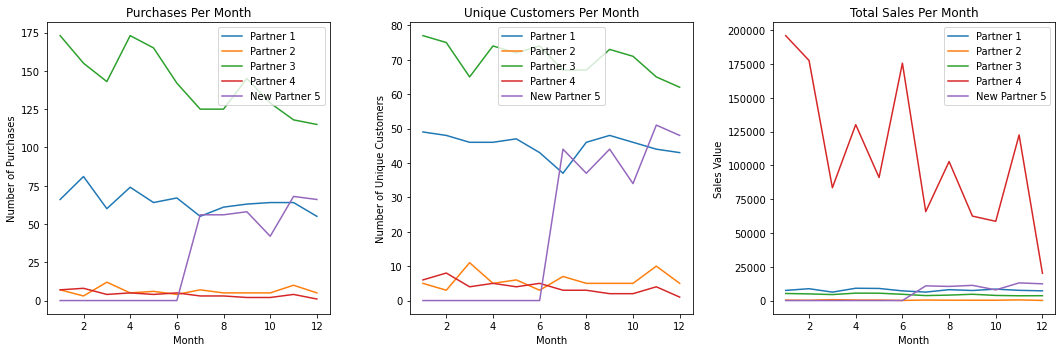

In [348]:
# Extracting metrics
months = list(range(1, 13))  # Representing months as numbers from 1 to 12

# Plot settings
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.5)

# Plotting Purchases Per Month for each partner
plt.subplot(1, 3, 1)
for partner in partner_metrics:
    plt.plot(months, partner_metrics[partner]["Purchases Per Month"], label=partner)
plt.title("Purchases Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Purchases")
plt.legend()

# Plotting Unique Customers Per Month for each partner
plt.subplot(1, 3, 2)
for partner in partner_metrics:
    plt.plot(months, partner_metrics[partner]["Unique Customers Per Month"], label=partner)
plt.title("Unique Customers Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Unique Customers")
plt.legend()

# Plotting Total Sales Per Month for each partner
plt.subplot(1, 3, 3)
for partner in partner_metrics:
    plt.plot(months, partner_metrics[partner]["Total Sales Per Month"], label=partner)
plt.title("Total Sales Per Month")
plt.xlabel("Month")
plt.ylabel("Sales Value")
plt.legend()

plt.tight_layout()
plt.show()

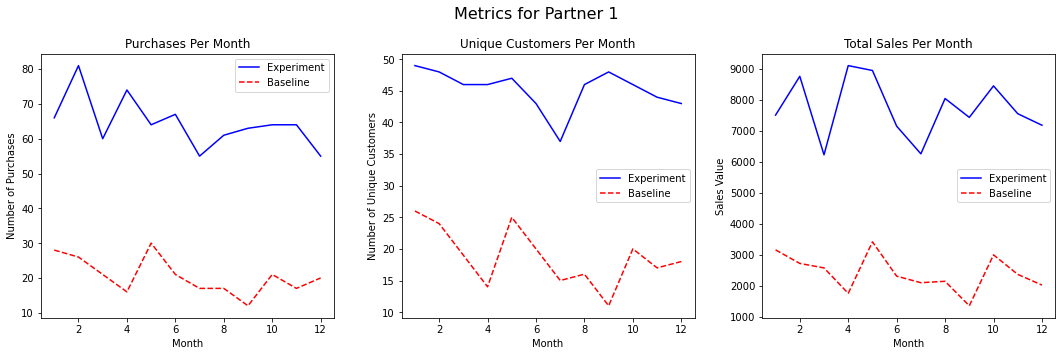

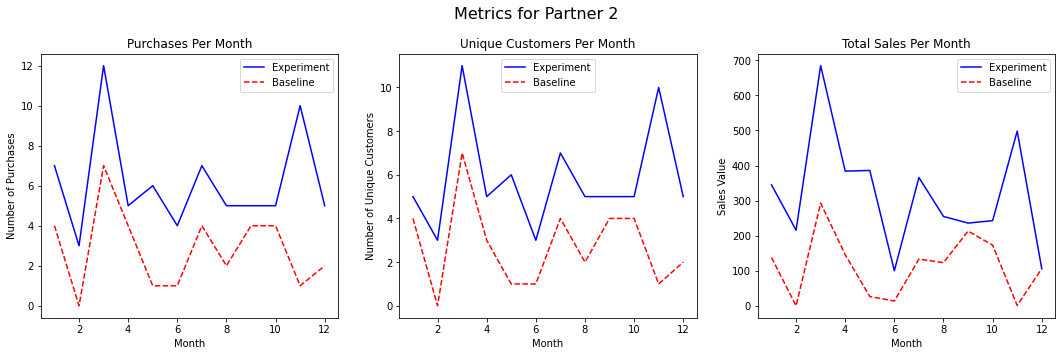

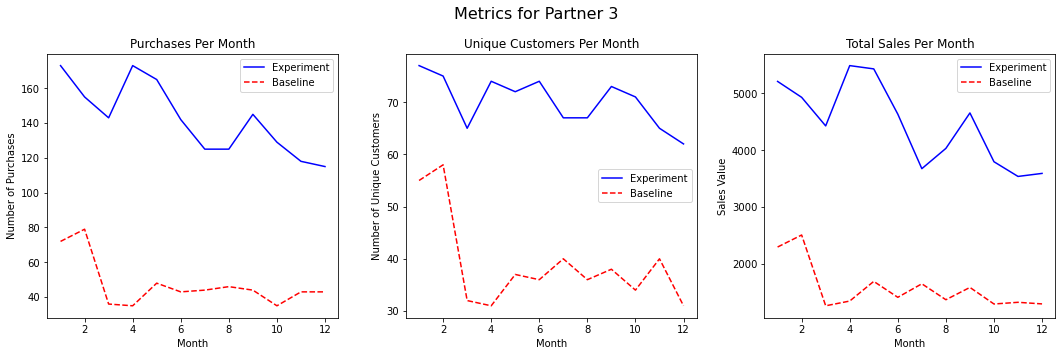

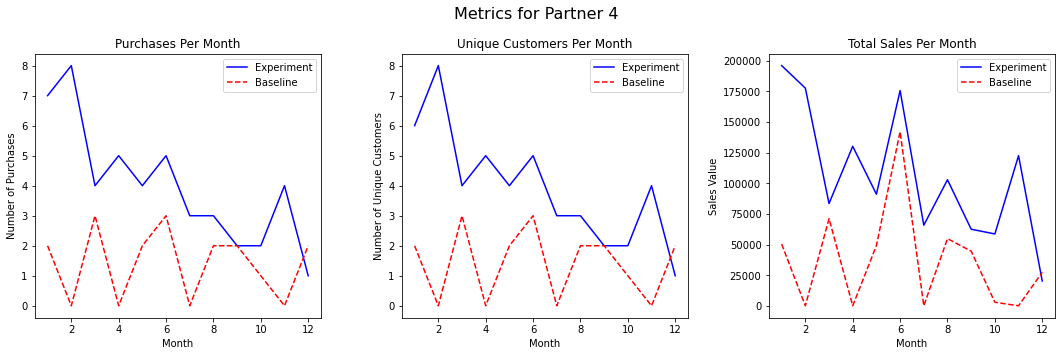

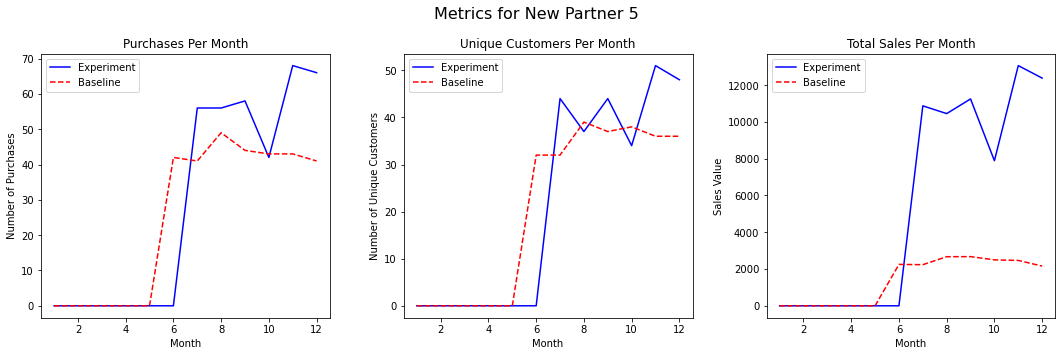

In [349]:
# Extracting metrics
months = list(range(1, 13))  # Representing months as numbers from 1 to 12

# For each partner, create a comparison plot
for partner in partner_metrics:

    # Plot settings
    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(f"Metrics for {partner}", fontsize=16)

    # Plotting Purchases Per Month comparison
    plt.subplot(1, 3, 1)
    plt.plot(months, partner_metrics[partner]["Purchases Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Purchases Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Purchases Per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Purchases")
    plt.legend()

    # Plotting Unique Customers Per Month comparison
    plt.subplot(1, 3, 2)
    plt.plot(months, partner_metrics[partner]["Unique Customers Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Unique Customers Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Unique Customers Per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Unique Customers")
    plt.legend()

    # Plotting Total Sales Per Month comparison
    plt.subplot(1, 3, 3)
    plt.plot(months, partner_metrics[partner]["Total Sales Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Total Sales Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Total Sales Per Month")
    plt.xlabel("Month")
    plt.ylabel("Sales Value")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title spacing
    plt.show()

# Comparative Charts (Partner Key Metrics): Baseline vs. Tokenomics 1

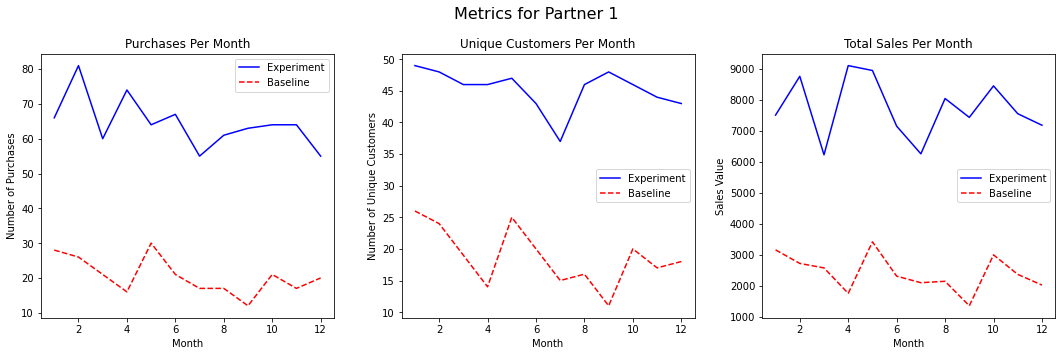

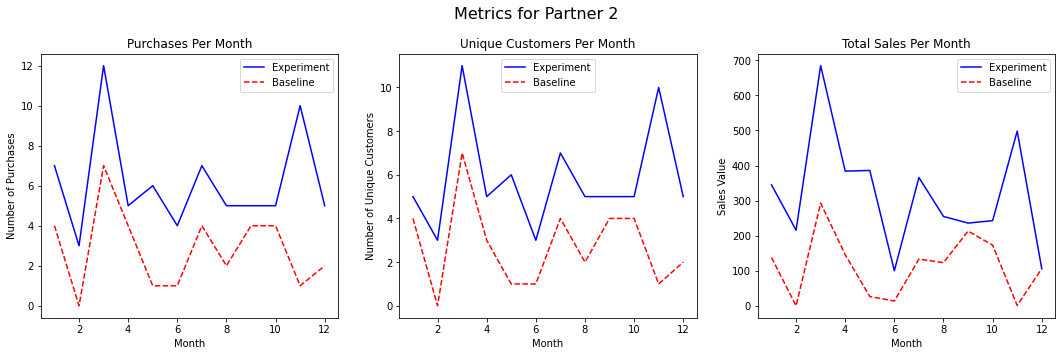

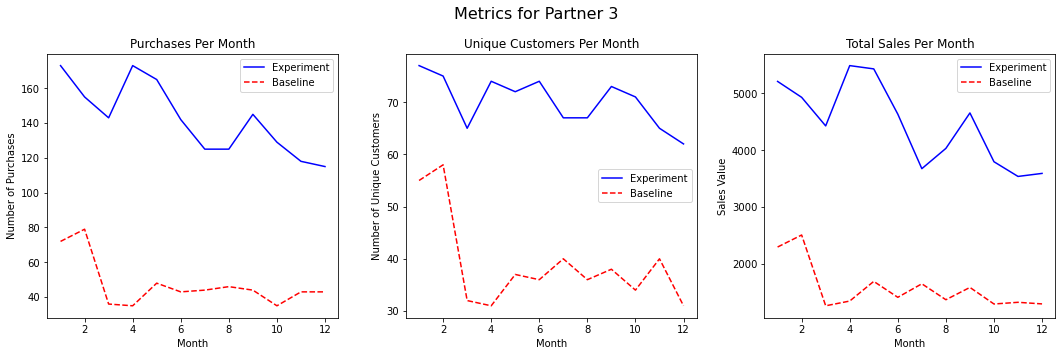

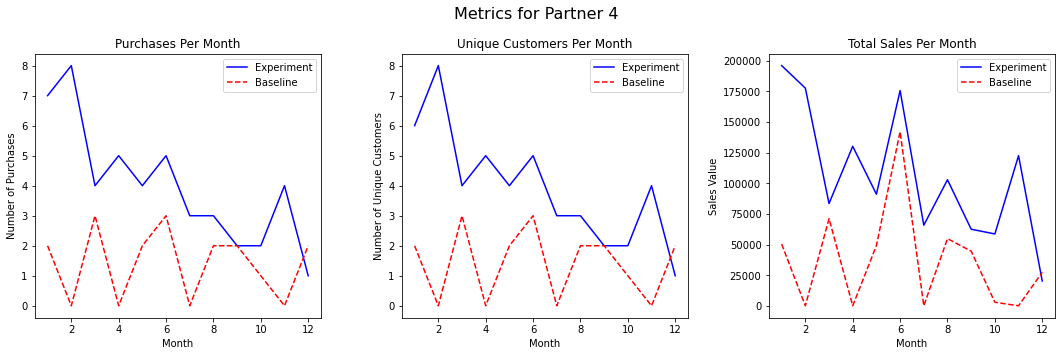

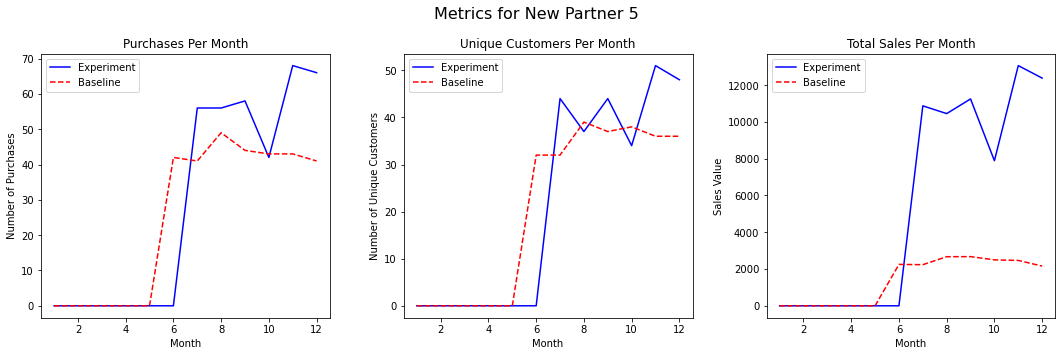

In [350]:
# Extracting metrics
months = list(range(1, 13))  # Representing months as numbers from 1 to 12

# For each partner, create a comparison plot
for partner in partner_metrics:

    # Plot settings
    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(wspace=0.5)
    plt.suptitle(f"Metrics for {partner}", fontsize=16)

    # Plotting Purchases Per Month comparison
    plt.subplot(1, 3, 1)
    plt.plot(months, partner_metrics[partner]["Purchases Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Purchases Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Purchases Per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Purchases")
    plt.legend()

    # Plotting Unique Customers Per Month comparison
    plt.subplot(1, 3, 2)
    plt.plot(months, partner_metrics[partner]["Unique Customers Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Unique Customers Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Unique Customers Per Month")
    plt.xlabel("Month")
    plt.ylabel("Number of Unique Customers")
    plt.legend()

    # Plotting Total Sales Per Month comparison
    plt.subplot(1, 3, 3)
    plt.plot(months, partner_metrics[partner]["Total Sales Per Month"], label='Experiment', color='blue')
    plt.plot(months, partner_metrics_baseline[partner]["Total Sales Per Month"], label='Baseline', linestyle='--', color='red')
    plt.title("Total Sales Per Month")
    plt.xlabel("Month")
    plt.ylabel("Sales Value")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust title spacing
    plt.show()